In [12]:
from mcap_ros2.reader import read_ros2_messages
import numpy as np

MCAP_PATH = '../ROS_bags/r2b_galileo_0.mcap'
TOPIC_NAME = '/front_stereo_camera/left/image_compressed'

def inspect_image_header():
    reader = read_ros2_messages(MCAP_PATH)
    
    for msg in reader:
        if msg.channel.topic == TOPIC_NAME:
            ros_msg = msg.ros_msg
            
            # 1. Print the format string (tells us what ROS *thinks* it is)
            fmt = getattr(ros_msg, 'format', 'unknown')
            
            # 2. Print the size
            data_len = len(ros_msg.data)
            
            # 3. Print the first 4 bytes (The "Magic Number")
            # JPEG should be: [255, 216, ...]
            # PNG  should be: [137, 80, 78, 71]
            header = list(ros_msg.data[:4])
            
            print(f"--- INSPECTION RESULT ---")
            print(f"Format String: '{fmt}'")
            print(f"Data Length:   {data_len} bytes")
            print(f"First 4 bytes: {header}")
            
            # Stop after checking the first one
            break

inspect_image_header()

--- INSPECTION RESULT ---
Format String: 'h264'
Data Length:   265683 bytes
First 4 bytes: [0, 0, 0, 1]


In [32]:
import subprocess

def convert_h264_to_mp4(h264_path, mp4_path):
    """
    Converts a raw H.264 bitstream to MP4 using ffmpeg without re-encoding.
    """
    cmd = [
        "ffmpeg",
        "-y",                # overwrite output
        "-framerate", "30",  # <-- if you know FPS, set here. Otherwise adjust.
        "-i", h264_path,
        "-c", "copy",        # copy the encoded video as-is (no re-encode)
        mp4_path
    ]

    print("Converting H.264 to MP4...")
    subprocess.run(cmd, check=True)
    print(f"Saved MP4: {mp4_path}")

Step 1: Extracting H.264 stream to ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\temp_stream.h264...
Extracted 352 video packets.
Step 2: Decoding video frames...
Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\frame_0000.jpg


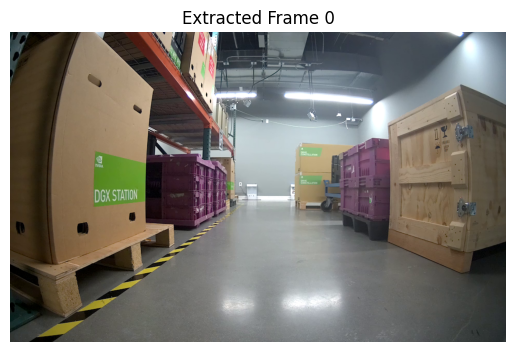

Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\frame_0010.jpg
Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\frame_0020.jpg
Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\frame_0030.jpg
Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\frame_0040.jpg
Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\frame_0050.jpg
Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\frame_0060.jpg
Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\frame_0070.jpg
Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\frame_0080.jpg
Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\frame_0090.jpg
Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/right/image_compressed\frame_0100.jpg
Saved ../Pictures_&_Videos/ROS_BAGS\front_stereo_camera/righ

In [ ]:
import cv2
import numpy as np
import os
from mcap_ros2.reader import read_ros2_messages

MCAP_PATH = '../ROS_bags/r2b_galileo_0.mcap'
BASE_OUTPUT_DIR = '../Pictures_&_Videos/ROS_BAGS'
TOPIC_NAME = '/front_stereo_camera/right/image_compressed'

# Mac
# 1. Sanitize the topic name (remove leading slash so os.path.join works correctly)
safe_topic_path = TOPIC_NAME.lstrip('/')

# 2. Create the full directory path based on the topic
# Result: ../Pictures/ROS_BAGS/back_stereo_camera/right/image_compressed
OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, safe_topic_path)

# 3. Define the specific file paths INSIDE that directory
TEMP_VIDEO_FILE = os.path.join(OUTPUT_DIR, 'temp_stream.h264')
MP4_OUTPUT_FILE = TEMP_VIDEO_FILE.replace(".h264", ".mp4")

# Making sure the output directory exists 
os.makedirs(OUTPUT_DIR, exist_ok=True)


def extract_images_from_h264():
    print(f"Extracting H.264 stream to {TEMP_VIDEO_FILE}...")
    
    reader = read_ros2_messages(MCAP_PATH)
    count = 0
    
    with open(TEMP_VIDEO_FILE, "wb") as f:
        for msg in reader:
            if msg.channel.topic == TOPIC_NAME:
                # Write the raw bytes directly to the file
                f.write(msg.ros_msg.data)
                count += 1
    
    print(f"Extracted {count} video packets.")
    print("Decoding video frames...")
    
    # Open the raw H.264 file as a video
    cap = cv2.VideoCapture(TEMP_VIDEO_FILE)
    
    if not cap.isOpened():
        print("Error: Could not open the extracted video file.")
        return

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        
        # If no frame is returned, we reached the end of the video
        if not ret:
            break
            
        # Updated to save every 10th frame
        # Change this to 'if True:' to save every single frame, tried and not recommended for long videos
        if frame_idx % 10 == 0:
            output_filename = os.path.join(OUTPUT_DIR, f"frame_{frame_idx:04d}.jpg")
            cv2.imwrite(output_filename, frame)
            print(f"Saved {output_filename}")
            
            # Displaying the first extracted frame as a sanity check
            if frame_idx == 0:
                import matplotlib.pyplot as plt
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                plt.imshow(frame_rgb)
                plt.title(f"Extracted Frame {frame_idx}")
                plt.axis('off')
                plt.show()

        frame_idx += 1

    cap.release()
    print("Done!")

extract_images_from_h264()


# Convert the H.264 stream into an MP4 file, this part requeres ffmpeg to be installed in order to work, so you can simply comment this out if not needed
mp4_output = TEMP_VIDEO_FILE.replace(".h264", ".mp4")
convert_h264_to_mp4(TEMP_VIDEO_FILE, mp4_output)

# deleting the .h264 generated stream
os.remove(TEMP_VIDEO_FILE)

